# NN Practice on CIFAR Dataset

## Importing Libraries

In [1]:
# Basics
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# For CNN
import torch.nn as nn
import torch.nn.functional as F

# For Loss Func. And Optimization
import torch.optim as optim

# For Visual Representation
import matplotlib.pyplot as plt

print("Success")

Success


## Setup Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Number of samples processed before updating model
batch_size = 4 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)
# Image Categories
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

print("Success")

Files already downloaded and verified
Files already downloaded and verified
Success


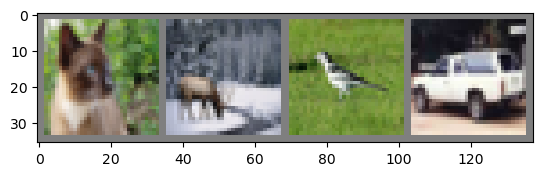

cat   deer  bird  car  


In [12]:
# Show image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Randomly selected training img
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Setup CNN

In [3]:
class Net(nn.Module):
    
    # Defining a network
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5) #Change argument 2 to experiment, must match argument 1 of conv 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5) #Change argument 1 to experiment, must match argument 2 of conv 1
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    # Defining forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [4]:
class MoreComplexNet(nn.Module):
    def __init__(self):
        super(MoreComplexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = MoreComplexNet()

In [8]:
# Setting up loss func. and optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = .001, momentum = 0.9)

## Training

In [9]:
from sklearn.model_selection import train_test_split

# Split dataset into train and validation sets
train_set, val_set = train_test_split(trainset, test_size=0.2, random_state=42)

# Dataloader for validation set
valloader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False, num_workers=2)


# Set up CUDA
# Setting up CUDA Device
if torch.cuda.is_available():
    print("Available")
    device = torch.device("cuda")
    print("")

net.to(device)


for epoch in range(5): # looping over dataset
    
    running_loss = 0.0
    
    # Training phase
    net.train()

    for i, data in enumerate(trainloader, 0):
        # get inputs
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        # return statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
    # Validation phase
    net.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # calculate accuracy for validation
            _, predicted = torch.max(outputs.data, 1)
            val_total_samples += labels.size(0)
            val_correct_predictions += (predicted == labels).sum().item()

    val_accuracy = val_correct_predictions / val_total_samples
    
    # Print loss and accuracy per epoch for both training and validation
    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader):.3f}, Validation Loss: {val_loss / len(valloader)}, Validation Accuracy: {val_accuracy:.2%}')
    print("")
    
print("Training Complete")

Available

[1,  2000] loss: 1.618
[1,  4000] loss: 1.485
[1,  6000] loss: 1.444
[1,  8000] loss: 1.404
[1, 10000] loss: 1.374
[1, 12000] loss: 1.373
Epoch 1, Training Loss: 0.053, Validation Loss: 1.2400492766410112, Validation Accuracy: 55.71%

[2,  2000] loss: 1.232
[2,  4000] loss: 1.245
[2,  6000] loss: 1.206
[2,  8000] loss: 1.223
[2, 10000] loss: 1.202
[2, 12000] loss: 1.209
Epoch 2, Training Loss: 0.049, Validation Loss: 1.069959378376603, Validation Accuracy: 62.27%

[3,  2000] loss: 1.089
[3,  4000] loss: 1.069
[3,  6000] loss: 1.092
[3,  8000] loss: 1.067
[3, 10000] loss: 1.070
[3, 12000] loss: 1.072
Epoch 3, Training Loss: 0.042, Validation Loss: 0.9469719630509615, Validation Accuracy: 66.22%

[4,  2000] loss: 0.932
[4,  4000] loss: 0.944
[4,  6000] loss: 0.958
[4,  8000] loss: 0.959
[4, 10000] loss: 0.959
[4, 12000] loss: 0.971
Epoch 4, Training Loss: 0.039, Validation Loss: 0.834315730712004, Validation Accuracy: 70.22%

[5,  2000] loss: 0.838
[5,  4000] loss: 0.835
[5,  

## Saving Model

In [10]:
PATH = './Models/cifar_net_Validation.pth'
torch.save(net.state_dict(), PATH)

## Testing Data

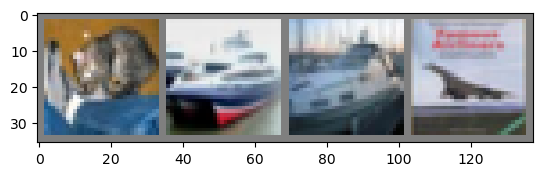

Truth:  cat   ship  ship  plane


In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# show img from test set
imshow(torchvision.utils.make_grid(images))
print('Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [18]:
# loading saved model
net = MoreComplexNet()
net.load_state_dict(torch.load('./Models/cifar_net_validation.pth'))

# Testing against above images
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  dog   car   ship  deer 


In [19]:
# Now test on entire dataset
correct = 0 
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        
        # Pick class with highest similarity score
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 57 %


In [20]:
# Breakdown
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 67.7 %
Accuracy for class: car   is 71.4 %
Accuracy for class: bird  is 44.4 %
Accuracy for class: cat   is 44.4 %
Accuracy for class: deer  is 45.6 %
Accuracy for class: dog   is 46.8 %
Accuracy for class: frog  is 64.1 %
Accuracy for class: horse is 66.5 %
Accuracy for class: ship  is 66.9 %
Accuracy for class: truck is 57.6 %


In [21]:
def write_accuracy_to_file(filename, correct, total, correct_pred, total_pred):
    # Open the specified text file in write mode
    with open(filename, 'w') as file:
        # Write overall accuracy to the file
        file.write(f'Total Epochs: {5}\n\n')
        file.write(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %\n\n')

        # Write accuracy for each class to the file
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            file.write(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %\n')


In [22]:
# Provide a filename (e.g., 'my_accuracy_results.txt') as an argument
write_accuracy_to_file('cifar_net_validation_accuracy.txt', correct, total, correct_pred, total_pred)